In [0]:
import re
import pandas as pd
import numpy as np

# Preprocesamiento
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Modelado
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

# Embeddings
from sentence_transformers import SentenceTransformer

# Reducción de dimensionalidad (opcional, pero recomendado para mejorar el rendimiento de DBSCAN)
from sklearn.decomposition import PCA

# Para combinar diferentes tipos de features
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Para manejar matrices dispersas
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

# Evaluación
from sklearn.metrics import silhouette_score

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

import pyspark.sql.functions as F

from sklearn.base import BaseEstimator, TransformerMixin

In [0]:
spark_df = spark.table("preprod_colombia.scraping_adidas_etiquetado")
spark_df_dkt = spark.table("preprod_colombia.scraping_dkt_etiquetado_running")

In [0]:
columns = ['Weight','Upper_Material','Midsole_Material','Outsole','Cushioning_System','Drop__heel-to-toe_differential_','regularPrice','undiscounted_price', 'Gender','Additional_Technologies',"id"]
columns_dkt = ['Weight','Upper_Material','Midsole_Material','Outsole','Cushioning_System','Drop__heel_to_toe_differential_','regularPrice','undiscounted_price', 'Gender','Additional_Technologies',"model_code"]
spark_df_selected = spark_df.select(columns)
spark_df_dkt_selected = spark_df_dkt.select(columns_dkt)


In [0]:
spark_df_dkt_selected = spark_df_dkt_selected.withColumnRenamed("model_code", "id")
spark_df_dkt_selected = spark_df_dkt_selected.withColumnRenamed("drop__heel_to_toe_differential_", "Drop__heel-to-toe_differential_")
spark_df_dkt_selected = spark_df_dkt_selected.withColumn("Drop__heel-to-toe_differential_",F.col("Drop__heel-to-toe_differential_").cast("string"))
spark_df_dkt_selected = spark_df_dkt_selected.withColumn("regularPrice",F.col("regularPrice").cast("int"))
spark_df_dkt_selected = spark_df_dkt_selected.withColumn("undiscounted_price",F.col("undiscounted_price").cast("int"))
spark_df_dkt_selected = spark_df_dkt_selected.withColumn(
    "Upper_Material", 
    F.regexp_replace(F.col("Upper_Material"), "Poliéster", "")
)

spark_df_dkt_selected = spark_df_dkt_selected.withColumn(
    "Upper_Material", 
    F.regexp_replace(F.col("Upper_Material"), "Poliuretano", "")
)

In [0]:
df_adidas = spark_df_selected.toPandas()
df_dkt = spark_df_dkt_selected.toPandas()
df = pd.concat([df_adidas, df_dkt], ignore_index=True)

In [0]:
df.tail(20)

,Weight,Upper_Material,Midsole_Material,Outsole,Cushioning_System,Drop__heel-to-toe_differential_,regularPrice,undiscounted_price,Gender,Additional_Technologies,id
469,NaN,"Poliamida, ;",EVA,Acetato de etileno y vinilo,,None,199000,NaN,Hombre,,8803408
470,251.0,", termoplástico",EVA,"Caucho sintético, Acetato de etileno y vinilo",flexibles (61 N/mm),4.0,249000,NaN,Hombre,Transpirabilidad: Nueva tela mesh desarrollada...,8670191
471,295.0,",",Entresuela de espuma EVA y concepto de amortig...,"Caucho sintético, Acetato de etileno y vinilo",,10.0,250000,229000.0,Hombre,Suela estriada de 3 mm para más agarre en cami...,8488639
472,366.0,,EVA,Acetato de etileno y vinilo,flexibilidad,None,139000,NaN,Mujer,,8803078
473,243.0,",",IMEVA,"Caucho sintético, Acetato de etileno y vinilo",Flexibilidad,4.0,185000,NaN,Hombre,,8757334
474,295.0,",",Entresuela de espuma EVA y concepto de amortig...,"Caucho sintético, Acetato de etileno y vinilo",,10.0,250000,229000.0,Hombre,Agarre: Suela estriada de 3 mm para más agarre...,8767790
475,251.0,", termoplástico",EVA,"Caucho sintético, Acetato de etileno y vinilo",tenis flexibles (61 N/mm),4.0,249000,NaN,Hombre,Libertad de movimientos: Las hendiduras de fle...,8670196
476,NaN,"termoplástico,",EVA,"Caucho sintético, Acetato de etileno y vinilo",Flex-H,None,249000,NaN,Mujer,Adaptabilidad: Disponible en dos anchos de pie...,8750403
477,200.0,",",IMEVA,"Caucho sintético, Acetato de etileno y vinilo",Flexibilidad,4.0,185000,NaN,Mujer,,8757345
478,180.0,",",,Acetato de etileno y vinilo;,,10.0,87000,79000.0,Hombre,,8351755


## Funciones

In [0]:
# Definir una función para combinar textos relevantes
def combine_text(row):
    text_fields = categorical_cols
    combined_text = ' '.join([str(row[field]) if pd.notnull(row[field]) else '' for field in text_fields])
    return combined_text

def preprocess_outsole(text):
    if pd.isna(text):
        return "Desconocido"
    # Reemplazar porcentajes o valores numericos por una etiqueta genérica
    text = re.sub(r'\d+(\.\d+)?\%?', 'X%', text)
    # Unificar materiales
    text = text.replace("Acetato de etileno y vinilo", "EVA")
    text = text.replace("Caucho sintético", "CauchoSintetico")
    # Quitar espacios extra
    text = re.sub(r'\s+', ' ', text).strip()
    return text



## Procesamiento del dataframe

In [0]:
#Remplaza los caracteres no numéricos
df['Weight'] = df['Weight'].apply(lambda x: re.sub(r'[^\d.]', '', str(x)))
df['Drop__heel-to-toe_differential_'] = df['Drop__heel-to-toe_differential_'].apply(lambda x: re.sub(r'[^\d.]', '', str(x)))
df['regularPrice'] = df['regularPrice'].apply(lambda x: re.sub(r'\D', '', str(x)))
df['undiscounted_price'] = df['undiscounted_price'].apply(lambda x: re.sub(r'\D', '', str(x)))

In [0]:
df['Weight'] = df['Weight'].replace('', np.nan)
df['Drop__heel-to-toe_differential_'] = df['Drop__heel-to-toe_differential_'].replace('', np.nan)
df['regularPrice'] = df['regularPrice'].replace('', np.nan)
df['undiscounted_price'] = df['undiscounted_price'].replace('', np.nan)

In [0]:
df['Weight'] = df['Weight'].astype(float)
df['Drop__heel-to-toe_differential_'] = df['Drop__heel-to-toe_differential_'].astype(float)
df['regularPrice'] = df['regularPrice'].astype(float)
df['undiscounted_price'] = df['undiscounted_price'].astype(float)

In [0]:
df['percentil_discounted'] = 1-(df['undiscounted_price']/df['regularPrice'])

In [0]:
df_reduced = df[['Weight','Upper_Material','Midsole_Material','Outsole','Cushioning_System','Drop__heel-to-toe_differential_','regularPrice','undiscounted_price','percentil_discounted', 'Gender','Additional_Technologies']]

In [0]:
df_reduced

,Weight,Upper_Material,Midsole_Material,Outsole,Cushioning_System,Drop__heel-to-toe_differential_,regularPrice,undiscounted_price,percentil_discounted,Gender,Additional_Technologies
0,183.0,Synthetic,null,Textile rubber,Lightstrike Pro,6.0,1299950.0,909965.0,0.300000,Woman,"ENERGYRODS 2.0, Waterproofing, Recyclable mate..."
1,289.0,adidas Primeknit,BOOST,Stretchweb with Continental Better Rubber,Linear Energy Push,NaN,799950.0,NaN,NaN,Woman,"Parley Ocean Plastic, waterproofing"
2,166.0,Parte superior de malla técnica,null,Suela de caucho Continental™,Amortiguación Lightstrike Pro,6.0,1049950.0,629970.0,0.400000,Mujer,Contiene al menos un 20 % de material reciclad...
3,200.0,Parte superior de malla,null,Suela de caucho Continental Rubber,Amortiguación Lightstrike Pro,6.0,1049950.0,734965.0,0.300000,Hombre,"Varillas ENERGYRODS, Talón Slinglaunch, Contie..."
4,319.0,Parte superior textil,Mediasuela Cloudfoam,Suela de TPU,Cloudfoam,6.0,279950.0,NaN,NaN,Hombre,null
...,...,...,...,...,...,...,...,...,...,...,...
484,216.0,"termoplástico, ;",VFOAM,"Caucho sintético, Acetato de etileno y vinilo,...",Pebax,8.0,399000.0,2400000.0,-5.015038,mujer,"geometría de la suela de las KIPRUN KD500 2, c..."
485,280.0,"termoplástico, ;",Kalensole,"Caucho sintético, Acetato de etileno y vinilo",Kalensole,6.0,309000.0,NaN,NaN,Hombre,
486,252.0,", termoplástico,",espuma MFOAM,"Caucho sintético, Acetato de etileno y vinilo",espuma MFOAM,6.0,499000.0,NaN,NaN,Hombre,Adherencia: Buen agarre en piso mojado gracias...
487,225.0,",",,"Caucho sintético, Carbono, Amida de bloque de ...",,8.0,849000.0,NaN,NaN,Hombre,Impulso: Espuma Pebax® de Arkema y placa de ca...


In [0]:
df_reduced.columns

Index(['Weight', 'Upper_Material', 'Midsole_Material', 'Outsole',
       'Cushioning_System', 'Drop__heel-to-toe_differential_', 'regularPrice',
       'undiscounted_price', 'percentil_discounted', 'Gender',
       'Additional_Technologies'],
      dtype='object')

In [0]:
df_reduced['Outsole'] = df_reduced['Outsole'].apply(preprocess_outsole)

/root/.ipykernel/1017/command-2628091764913739-2217468474:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['Outsole'] = df_reduced['Outsole'].apply(preprocess_outsole)


## Clustering

In [0]:
 
 # Identificar columnas numéricas y categóricas
numerical_cols = ['Drop__heel-to-toe_differential_','Weight', 'regularPrice','undiscounted_price','percentil_discounted']
categorical_cols = ['Midsole_Material', 'Cushioning_System', 'Outsole', 'Upper_Material', 
                    'Additional_Technologies', 'Gender']
 
# Definir qué columnas numéricas se imputarán con mediana y escalado
numeric_impute_cols = ['regularPrice']

# Definir columnas numéricas "especiales" que no se deben imputar con mediana
special_numeric_cols = ['Drop__heel-to-toe_differential_', 'percentil_discounted','Weight', 'undiscounted_price']

###################################
# Transformador personalizado
###################################
class SpecialNumericToCategory(BaseEstimator, TransformerMixin):
 
    """
    Este transformador convierte las columnas numéricas "especiales" en categorías.
    Por ejemplo:
    - Si el valor es NaN, lo marca como "NoValue".
    - Si tiene valor, lo convierte a una categoría del tipo "Value:X".
    """
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.cols:
            X[col] = X[col].apply(lambda val: 'NoValue' if pd.isna(val) else f'Value:{val}')
        return X[self.cols]

###################################
# Pipelines
###################################

# Pipeline para columnas numéricas "normales"
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Imputar con mediana
    ('scaler', StandardScaler())                    # Escalar a media=0, std=1
])

# Pipeline para columnas numéricas "especiales", convertidas a categóricas
special_numeric_pipeline = Pipeline(steps=[
    ('to_category', SpecialNumericToCategory(special_numeric_cols)),
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline para columnas categóricas normales
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar todos los pipelines con ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_impute_cols),
    ('special_num', special_numeric_pipeline, special_numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
])
X_transformed = preprocessor.fit_transform(df_reduced)
feature_names = (preprocessor.named_transformers_['num'][-1].get_feature_names_out(numeric_impute_cols).tolist() 
                 + preprocessor.named_transformers_['special_num'][-1].get_feature_names_out(special_numeric_cols).tolist()
                 + preprocessor.named_transformers_['cat'][-1].get_feature_names_out(categorical_cols).tolist())


Preprocesando columnas numéricas...
Generando embeddings para columnas categóricas...
Concatenando características numéricas y categóricas...
Aplicando PCA para reducir dimensiones...
Calculando el Método del Codo para determinar el número óptimo de clusters...


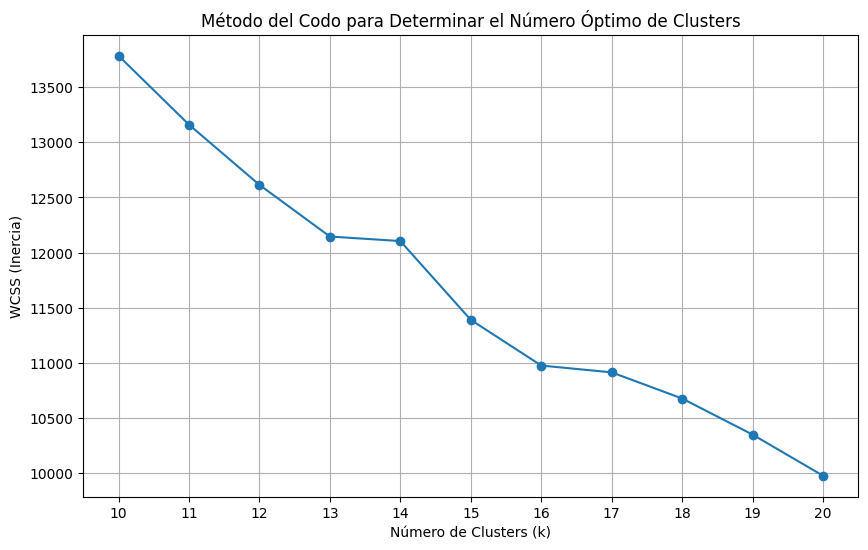

Calculando el Silhouette Score para diferentes valores de k...


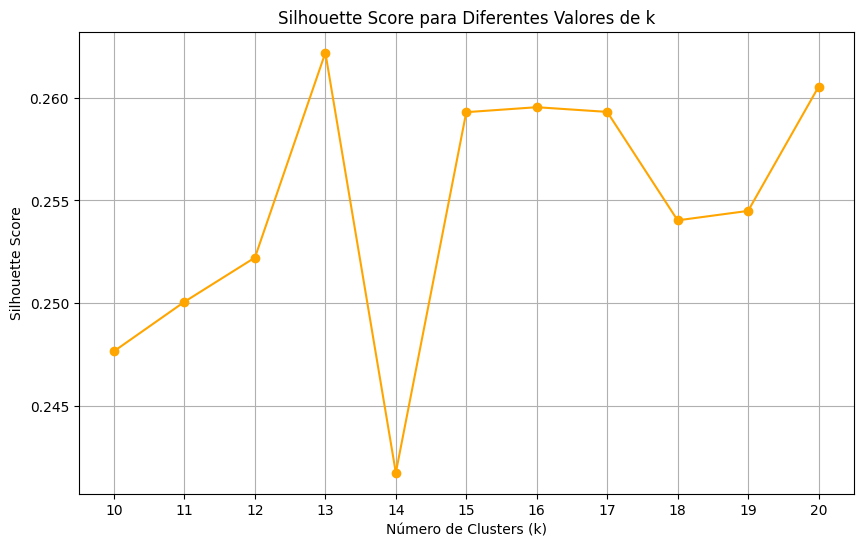

El número óptimo de clusters según el Silhouette Score es: 13
Aplicando K-Means con k=13...

Número de clusters encontrados: 13
Reduciendo dimensiones para visualización con t-SNE...


/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


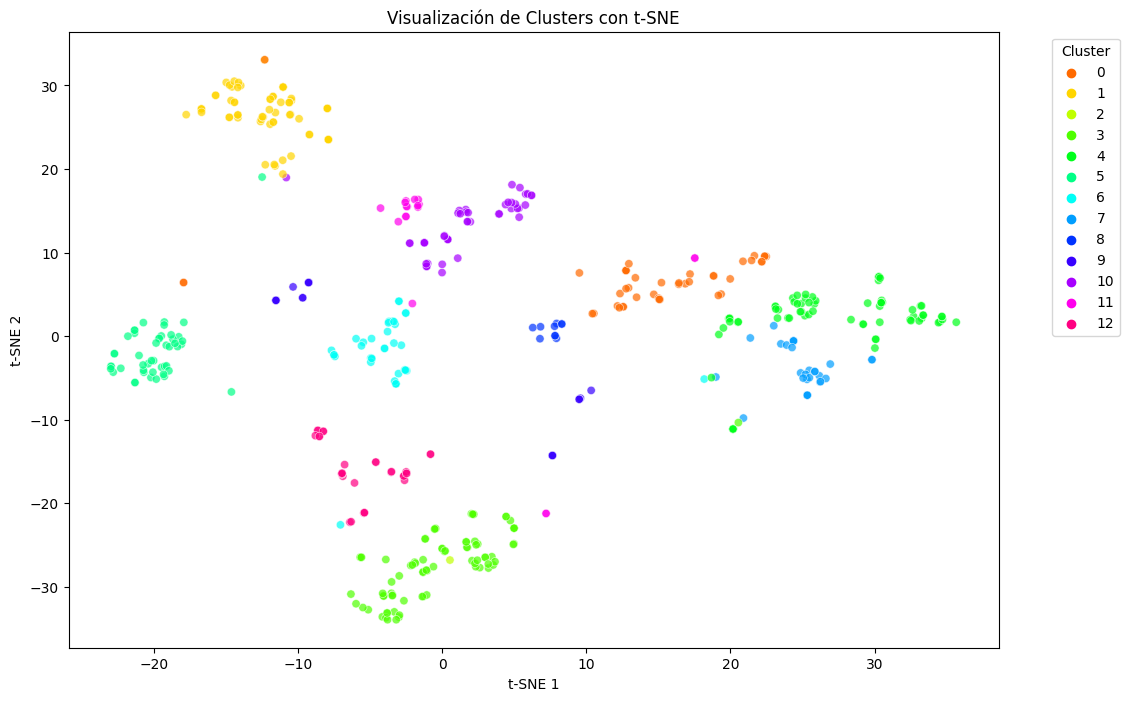


Resumen de Clusters:
3     80
4     70
1     62
5     48
10    45
0     42
6     38
12    31
7     28
11    18
9     16
8     10
2      1
Name: Cluster, dtype: int64


In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suponemos que ya tienes df, df_reduced, numerical_cols, categorical_cols definidos
# y que df_reduced contiene las columnas requeridas.

model = SentenceTransformer('all-MiniLM-L6-v2')

# Preprocesar columnas numéricas
print("Preprocesando columnas numéricas...")
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(df_reduced[numerical_cols].fillna(0))

# Generar embeddings para columnas categóricas
print("Generando embeddings para columnas categóricas...")
categorical_embeddings = []
for col in categorical_cols:
    embeddings = model.encode(df_reduced[col].fillna('Unknown').astype(str).tolist())
    categorical_embeddings.append(embeddings)

# Asignar importancia a las columnas categóricas según el orden dado
# Asumiendo el orden de categorical_cols:
# ['Midsole_Material', 'Cushioning_System', 'Additional_Technologies', 'Outsole', ...]
Midsole_Material_embeddings = categorical_embeddings[0] * 5.0      # 1ra prioridad
Cushioning_System_embeddings = categorical_embeddings[1] * 5.0      # 1ra prioridad
Additional_Technologies_embeddings = categorical_embeddings[2] * 2.0 # info adicional
Outsole_embeddings = categorical_embeddings[3] * 3.0                # 3ra prioridad

# Otras columnas categóricas (si las hay)
if len(categorical_embeddings) > 4:
    other_cat_embeddings = np.hstack(categorical_embeddings[4:])
else:
    other_cat_embeddings = np.empty((len(df_reduced), 0))

# Ajustar importancia en las variables numéricas:
# numerical_cols = ['Drop__heel-to-toe_differential_','Weight','regularPrice','undiscounted_price','percentil_discounted']
drop_idx = numerical_cols.index('Drop__heel-to-toe_differential_')
weight_idx = numerical_cols.index('Weight')
regular_price_idx = numerical_cols.index('regularPrice')

# Aplicar factores
numerical_scaled[:, drop_idx] *= 4.0     # 2da prioridad
numerical_scaled[:, weight_idx] *= 2.0   # 5ta prioridad
numerical_scaled[:, regular_price_idx] *= 1.5 # 6ta prioridad

# Combinar embeddings categóricos con sus factores
combined_categorical_embeddings = np.hstack([
    Midsole_Material_embeddings,
    Cushioning_System_embeddings,
    Additional_Technologies_embeddings,
    Outsole_embeddings,
    other_cat_embeddings
])

# Combinar características numéricas y categóricas sin volver a escalar,
# para no perder la ponderación manual
print("Concatenando características numéricas y categóricas...")
combined_features = np.hstack([numerical_scaled, combined_categorical_embeddings])

# Ahora aplicamos PCA, k-means, etc., sobre combined_features
print("Aplicando PCA para reducir dimensiones...")
pca = PCA(n_components=400, random_state=42)  # Ajusta n_components según necesidad
reduced_features = pca.fit_transform(combined_features)

print("Calculando el Método del Codo para determinar el número óptimo de clusters...")
wcss = []
k_values = range(10, 21)  # Rango de k para explorar

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(reduced_features)
    wcss.append(kmeans.inertia_)

# Visualizar el Método del Codo
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o')
plt.title('Método del Codo para Determinar el Número Óptimo de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS (Inercia)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

print("Calculando el Silhouette Score para diferentes valores de k...")
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(reduced_features)
    score = silhouette_score(reduced_features, clusters)
    silhouette_scores.append(score)

# Visualizar el Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score para Diferentes Valores de k')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(silhouette_scores)]
print(f"El número óptimo de clusters según el Silhouette Score es: {best_k}")

print(f"Aplicando K-Means con k={best_k}...")
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters_final = kmeans_final.fit_predict(reduced_features)

# Añadir etiquetas de cluster al DataFrame original
df['Cluster'] = clusters_final

n_clusters_final = len(set(clusters_final))
print(f'\nNúmero de clusters encontrados: {n_clusters_final}')

print("Reduciendo dimensiones para visualización con t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(reduced_features)

df['tsne-2d-one'] = tsne_results[:, 0]
df['tsne-2d-two'] = tsne_results[:, 1]

plt.figure(figsize=(12, 8))
palette = sns.color_palette("hsv", n_clusters_final)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Cluster",
    palette=palette,
    data=df,
    legend="full",
    alpha=0.7
)
plt.title('Visualización de Clusters con t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

print("\nResumen de Clusters:")
print(df['Cluster'].value_counts())


Aplicando PCA para reducir dimensiones...
Calculando el Método del Codo para determinar el número óptimo de clusters...


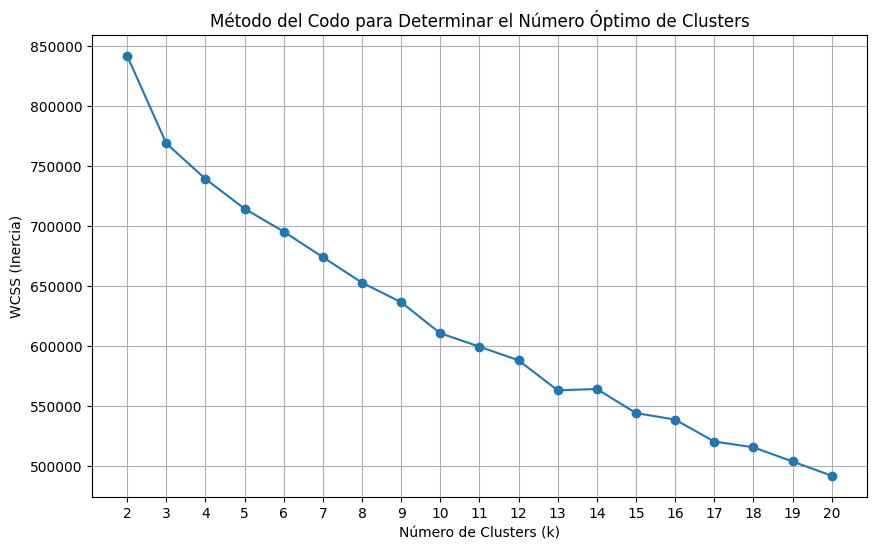

Calculando el Silhouette Score para diferentes valores de k...


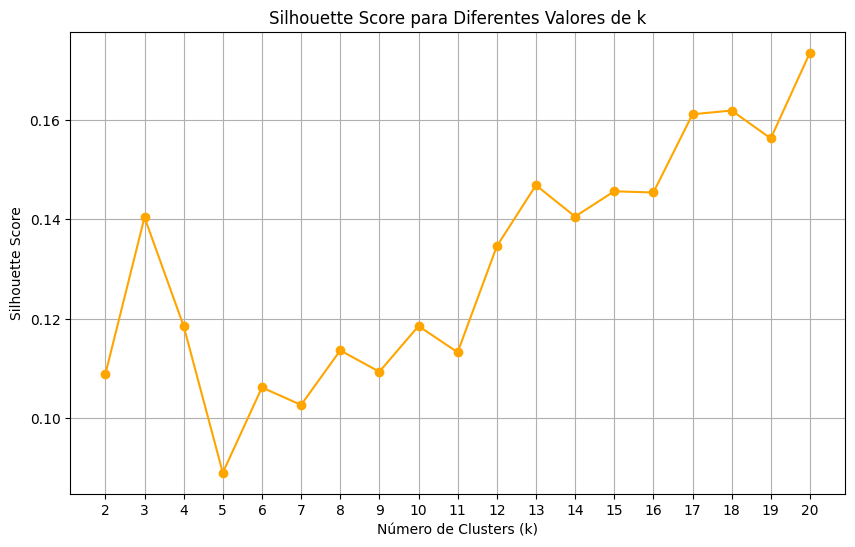

El número óptimo de clusters según el Silhouette Score es: 20
Aplicando K-Means con k=20...

Número de clusters encontrados: 20
Reduciendo dimensiones para visualización con t-SNE...


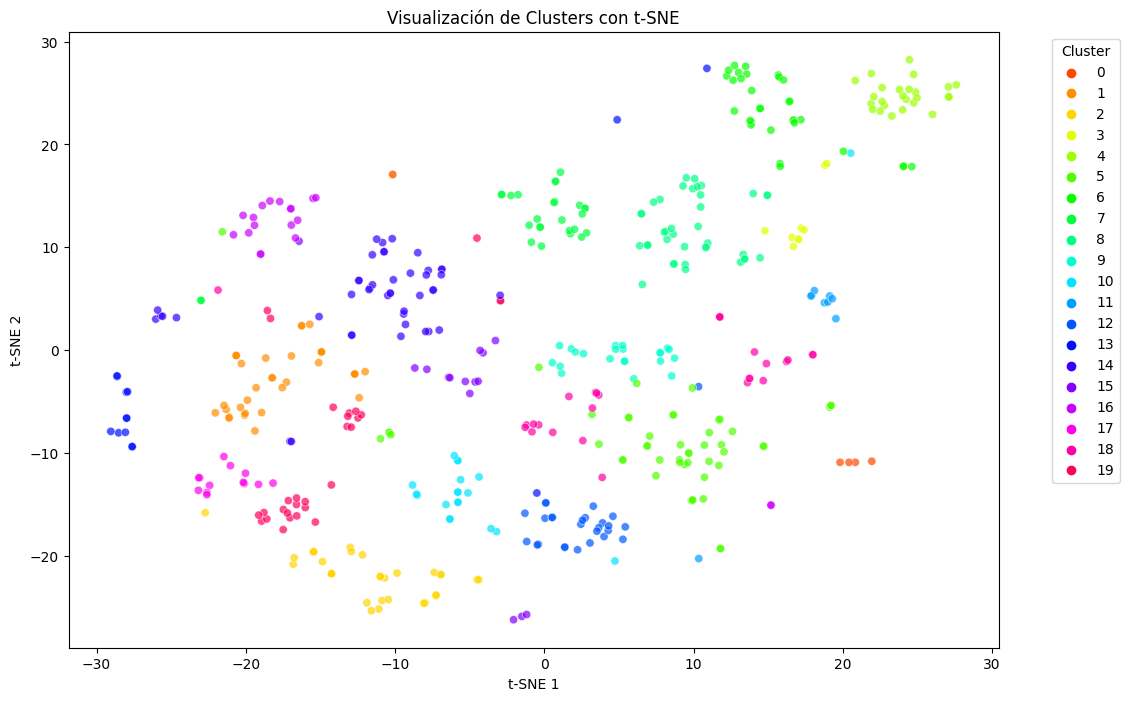


Resumen de Clusters:
5     49
14    44
8     38
1     35
2     31
6     31
19    30
18    27
7     27
12    27
4     25
9     22
10    20
16    19
15    15
13    14
17    13
11     9
3      9
0      4
Name: Cluster, dtype: int64

Cluster 0:
     Weight             Upper_Material  ... tsne-2d-one tsne-2d-two
68    278.0  Exterior de malla técnica  ...   19.815088  -10.885159
74      NaN          Exterior de malla  ...   21.941719  -10.785176
165   330.0  Exterior de malla técnica  ...   20.837984  -10.885697
282   330.0  Exterior de malla técnica  ...   20.412170  -10.892855

[4 rows x 15 columns]

Cluster 1:
    Weight           Upper_Material  ... tsne-2d-one tsne-2d-two
19   320.0    Parte superior textil  ...  -21.108912   -6.493203
46   323.0  Parte superior de malla  ...  -15.119090   -1.197047
47   364.0          Exterior textil  ...  -18.662340   -0.758213
48   286.0    Parte superior textil  ...  -19.311958   -3.636598
96     NaN        Exterior de malla  ...  -12.407335   -4.

In [0]:
"""
# Reducción de dimensionalidad con PCA
print("Aplicando PCA para reducir dimensiones...")
pca = PCA(n_components=489, random_state=42)
reduced_features = pca.fit_transform(scaled_features)

# -------------------- Determinación del Número Óptimo de Clusters --------------------
print("Calculando el Método del Codo para determinar el número óptimo de clusters...")
wcss = []
k_values = range(2, 21)  # Rango de k para explorar

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(reduced_features)
    wcss.append(kmeans.inertia_)

# Visualizar el Método del Codo
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o')
plt.title('Método del Codo para Determinar el Número Óptimo de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS (Inercia)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Silhouette Score
print("Calculando el Silhouette Score para diferentes valores de k...")
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(reduced_features)
    score = silhouette_score(reduced_features, clusters)
    silhouette_scores.append(score)

# Visualizar el Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score para Diferentes Valores de k')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Determinar el mejor k basado en el Silhouette Score
best_k = k_values[np.argmax(silhouette_scores)]
print(f"El número óptimo de clusters según el Silhouette Score es: {best_k}")

# -------------------- Aplicar K-Means con el Número Óptimo de Clusters --------------------
print(f"Aplicando K-Means con k={best_k}...")
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters_final = kmeans_final.fit_predict(reduced_features)

# Añadir etiquetas de cluster al DataFrame original
df['Cluster'] = clusters_final

# Resumen final de clusters
n_clusters_final = len(set(clusters_final))
print(f'\nNúmero de clusters encontrados: {n_clusters_final}')

# -------------------- Visualización de los Clusters --------------------
print("Reduciendo dimensiones para visualización con t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(reduced_features)

df['tsne-2d-one'] = tsne_results[:, 0]
df['tsne-2d-two'] = tsne_results[:, 1]

plt.figure(figsize=(12, 8))
palette = sns.color_palette("hsv", n_clusters_final)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Cluster",
    palette=palette,
    data=df,
    legend="full",
    alpha=0.7
)
plt.title('Visualización de Clusters con t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# -------------------- Análisis de Clusters --------------------
print("\nResumen de Clusters:")
print(df['Cluster'].value_counts())

# Opcional: Ver registros en cada cluster
for cluster in range(n_clusters_final):
    print(f'\nCluster {cluster}:')
    print(df[df['Cluster'] == cluster].head())"""


In [0]:
df.tail(30)

,Weight,Upper_Material,Midsole_Material,Outsole,Cushioning_System,Drop__heel-to-toe_differential_,regularPrice,undiscounted_price,Gender,Additional_Technologies,id,percentil_discounted,Cluster,tsne-2d-one,tsne-2d-two
459,169.0,",",,100.0 Acetato de etileno y vinilo,,10.0,87000.0,790000.0,,,8351800,-8.080460,8,8.291100,1.462351
460,248.0,", termoplástico",EVA,70.0 Acetato de etileno y vinilo 30.0 Caucho,EVA,4.0,330000.0,NaN,mujer,Las hendiduras de flexión acompañan la extensi...,8670212,NaN,0,16.408499,6.210423
461,315.0,", ;",EVA,100.0 Caucho sintético,EVA,8.0,299000.0,NaN,Hombre,,8642811,NaN,0,16.423395,6.361099
462,255.0,",",,"60.0 Caucho sintético, 40.0 Acetato de etileno...",,10.0,250000.0,2290000.0,mujer,,8572326,-8.160000,8,7.796293,1.183642
463,NaN,", .",EVA,"Caucho sintético, Acetato de etileno y vinilo","Kalensole , CS (Circular System)",10.0,275000.0,NaN,Hombre,,8666719,NaN,0,12.334808,5.093338
464,240.0,", termoplástico, termoplástico",,"Caucho sintético, Acetato de etileno y vinilo",espuma Kalensole) y absorción impactos (CS).,NaN,426000.0,3090000.0,Mujer,,8767800,-6.253521,8,6.819094,1.120482
465,NaN,"termoplástico,",EVA,"Caucho sintético, Acetato de etileno y vinilo",,NaN,249000.0,NaN,Hombre,,8759629,NaN,0,12.555698,3.515450
466,243.0,",",IMEVA,"Caucho sintético, Acetato de etileno y vinilo",Flexibilidad,4.0,185000.0,NaN,Hombre,,8757332,NaN,0,12.750481,7.847188
467,255.0,",",Entresuela de espuma EVA y concepto de amortig...,"Caucho sintético, Acetato de etileno y vinilo",Espumas gruesas en el talón y en la lengüeta.,10.0,250000.0,2290000.0,Mujer,Agarre: Suela estriada 3 mm para mayor agarre ...,8544265,-8.160000,8,7.923182,-0.259708
468,NaN,,EVA,"Caucho sintético, 80.0% Acetato de etileno y v...",Flexibilidad,NaN,199000.0,NaN,Hombre,Agarre: Gracias a las estrías y geometría de l...,8803397,NaN,0,12.929887,5.782633


In [0]:
spark_df_adidas = spark.createDataFrame(df)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:401: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Expected bytes, got a 'int' object
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


In [0]:
spark_df_adidas.write.mode("overwrite").saveAsTable("preprod_colombia.scraping_adidas_dkt_clusters")

## Clustering NIKE

In [0]:
spark_df_nr = spark.table("preprod_colombia.scraping_nacionrunner_etiquetado")

In [0]:
spark_df_selected = spark_df_nr.select(['Weight',
 'Upper_Material',
 'Midsole_Material',
 'Outsole',
 'Cushioning_System',
 'Drop__heel-to-toe_differential_',
 'Pronation_Type',
 'Usage_Type',
 'Gender',
 'Width',
 'Additional_Technologies',
 'regularPrice',
 'undiscounted_price']
)

In [0]:
df_nr = spark_df_selected.toPandas()

In [0]:
#Remplaza los caracteres no numéricos
df_nr['Weight'] = df_nr['Weight'].apply(lambda x: re.sub(r'[^\d.]', '', str(x)))
df_nr['Drop__heel-to-toe_differential_'] = df_nr['Drop__heel-to-toe_differential_'].apply(lambda x: re.sub(r'[^\d.]', '', str(x)))
df_nr['regularPrice'] = df_nr['regularPrice'].apply(lambda x: re.sub(r'\D', '', str(x)))
df_nr['undiscounted_price'] = df_nr['undiscounted_price'].apply(lambda x: re.sub(r'\D', '', str(x)))

In [0]:
df_nr['Weight'] = df_nr['Weight'].replace('', np.nan)
df_nr['Drop__heel-to-toe_differential_'] = df_nr['Drop__heel-to-toe_differential_'].replace('', np.nan)
df_nr['regularPrice'] = df_nr['regularPrice'].replace('', np.nan)
df_nr['undiscounted_price'] = df_nr['undiscounted_price'].replace('', np.nan)

In [0]:
df_nr['Weight'] = df_nr['Weight'].astype(float)
df_nr['Drop__heel-to-toe_differential_'] = df_nr['Drop__heel-to-toe_differential_'].astype(float)
df_nr['regularPrice'] = df_nr['regularPrice'].astype(float)
df_nr['undiscounted_price'] = df_nr['undiscounted_price'].astype(float)

In [0]:
df_nr['percentil_discounted'] = 1-(df_nr['undiscounted_price']/df_nr['regularPrice'])

In [0]:
df_nr

,Weight,Upper_Material,Midsole_Material,Outsole,Cushioning_System,Drop__heel-to-toe_differential_,Pronation_Type,Usage_Type,Gender,Width,Additional_Technologies,regularPrice,undiscounted_price
0,242,Neutro,ProFly+,Asfalto,null,5,null,null,null,null,null,5999000,7499000
1,,Woven,FlyteFoam Blast+ ECO,AHAR,FlyteFoam Blast+ ECO,8,Neutro • Supinador,Entreno en pista,null,null,"Waterproofing, Reflectivity",6999000,
2,85,Mesh técnico,FF Blast Max,ASICS Grip y AHARPLUS,FF Blast Max,6,Neutral or Supinator,"Daily training, racing",Unisex,Standard,"Waterproofing, reflectivity",8499000,
3,305,null,FF BLAST PLUS ECO,Asfalto,4D Guidance System,10,null,"Daily Training, Racing",Men,null,"Waterproofing, Reflectivity, Customized Fit Sy...",8799000,
4,270,Technical Fabrics,PureGel,Asfalto,PureGel,8,Pronadores,Daily Training,Men,Standard,"FlyteFoam, OrthoLite Hybrid Max, Waterproofing",4999000,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,80,Malla Jacquard,EVA,Asfalto,MetaRocker,8,Neutral,Daily training,Unisex,null,"Waterproofing, Reflectivity",6999000,
181,,malla knit,"FlyteFoam BLAST PLUS ECO, PureGEL","ASICSGRIP, caucho AHAR PLUS","FlyteFoam BLAST PLUS ECO, PureGEL",8,"Neutro, Supinador","Daily training, Racing",null,null,null,6499000,8499000
182,282,Asfalto,J-Frame,Asfalto,J-Frame,5,Pronador,Daily training,Men,null,"Waterproofing, reflectivity, customized fit sy...",7499000,
183,275234,null,Amplifoam+,Asfalto,Equilibrada y Versatilidad,8,"Neutral, Supinador","Daily training, Racing",null,"Breathability, Transpirability",None,3299000,


In [0]:
df_nr.columns

Index(['Weight', 'Upper_Material', 'Midsole_Material', 'Outsole',
       'Cushioning_System', 'Drop__heel-to-toe_differential_',
       'Pronation_Type', 'Usage_Type', 'Gender', 'Width',
       'Additional_Technologies', 'regularPrice', 'undiscounted_price'],
      dtype='object')

In [0]:
# Identificar columnas numéricas y categóricas
numerical_cols = ['Weight', 'Drop__heel-to-toe_differential_','regularPrice','undiscounted_price','percentil_discounted']
categorical_cols = ['Upper_Material', 'Midsole_Material', 'Outsole', 'Pronation_Type', 'Usage_Type', 'Gender', 'Width',
                    'Cushioning_System', 'Additional_Technologies']

In [0]:
# Definir los pipelines de preprocesamiento
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Desconocido')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que ya tienes: 
# df_nr (DataFrame) con columnas numéricas en numerical_cols y categorías en categorical_cols
# df (DataFrame) que es el DataFrame base donde se añadirán los clusters
# model = SentenceTransformer('all-MiniLM-L6-v2')  # si aún lo necesitas para las columnas categóricas

# Preprocesar columnas numéricas y categóricas
print("Preprocesando columnas numéricas...")
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(df_nr[numerical_cols].fillna(0))

print("Generando embeddings para columnas categóricas...")
categorical_embeddings = []
for col in categorical_cols:
    embeddings = model.encode(df_nr[col].fillna('Unknown').astype(str).tolist())
    categorical_embeddings.append(embeddings)

combined_categorical_embeddings = np.hstack(categorical_embeddings)

# Combinar características numéricas y categóricas
print("Concatenando características numéricas y categóricas...")
combined_features = np.hstack([numerical_scaled, combined_categorical_embeddings])

# Escalar las características combinadas
print("Escalando características combinadas...")
scaled_features = scaler.fit_transform(combined_features)

# Reducción de dimensionalidad con PCA
print("Aplicando PCA para reducir dimensiones...")
pca = PCA(n_components=400, random_state=42)
reduced_features = pca.fit_transform(scaled_features)

# -------------------- Determinación del Número Óptimo de Clusters --------------------
print("Calculando el Método del Codo para determinar el número óptimo de clusters...")
wcss = []
k_values = range(2, 21)  # Rango de k para explorar

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(reduced_features)
    wcss.append(kmeans.inertia_)

# Visualizar el Método del Codo
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o')
plt.title('Método del Codo para Determinar el Número Óptimo de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS (Inercia)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Silhouette Score
print("Calculando el Silhouette Score para diferentes valores de k...")
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(reduced_features)
    score = silhouette_score(reduced_features, clusters)
    silhouette_scores.append(score)

# Visualizar el Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score para Diferentes Valores de k')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Determinar el mejor k basado en el Silhouette Score
best_k = k_values[np.argmax(silhouette_scores)]
print(f"El número óptimo de clusters según el Silhouette Score es: {best_k}")

# -------------------- Aplicar K-Means con el Número Óptimo de Clusters --------------------
print(f"Aplicando K-Means con k={best_k}...")
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters_final = kmeans_final.fit_predict(reduced_features)

# Añadir etiquetas de cluster al DataFrame original
df_nr['Cluster'] = clusters_final

# Resumen final de clusters
n_clusters_final = len(set(clusters_final))
print(f'\nNúmero de clusters encontrados: {n_clusters_final}')

# -------------------- Visualización de los Clusters --------------------
print("Reduciendo dimensiones para visualización con t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(reduced_features)

df_nr['tsne-2d-one'] = tsne_results[:, 0]
df_nr['tsne-2d-two'] = tsne_results[:, 1]

plt.figure(figsize=(12, 8))
palette = sns.color_palette("hsv", n_clusters_final)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Cluster",
    palette=palette,
    data=df_nr,
    legend="full",
    alpha=0.7
)
plt.title('Visualización de Clusters con t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# -------------------- Análisis de Clusters --------------------
print("\nResumen de Clusters:")
print(df_nr['Cluster'].value_counts())

# Opcional: Ver registros en cada cluster
for cluster in range(n_clusters_final):
    print(f'\nCluster {cluster}:')
    print(df_nr[df_nr['Cluster'] == cluster].head())


Preprocesando columnas numéricas...


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2628091764804198>, line 20
     18 print("Preprocesando columnas numéricas...")
     19 scaler = StandardScaler()
---> 20 numerical_scaled = scaler.fit_transform(df_nr[numerical_cols].fillna(0))
     22 print("Generando embeddings para columnas categóricas...")
     23 categorical_embeddings = []

NameError: name 'df_nr' is not defined

In [0]:
spark_df_nr = spark.createDataFrame(df_nr)

In [0]:
spark_df_nr.write.mode("overwrite").saveAsTable("preprod_colombia.scraping_nr_clusters")